<a href="https://colab.research.google.com/github/ImagingDataCommons/isbi_tutorial_2024/blob/main/ISBI_2024_hands_on.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook is part of a [tutorial given at ISBI 2024](https://biomedicalimaging.org/2024/tutorials-final/).
It demonstrates how the Imaging Data Commons (IDC) can be used to work with whole slide images (WSIs) and provides an example of the application of deep learning (DL) to computational pathology analysis.
In particular, a pre-trained model made available in the context of the publication [The NCI Imaging Data Commons as a platform for reproducible research in computational pathology](https://doi.org/10.1016/j.cmpb.2023.107839) is used to classify lung tissue regions into either non-neoplastic (normal), adenocarcinoma (LUAD), or squamous cell carcinoma (LSCC) tissue.  

# Prerequisites



**Step 1: Save notebook to Google Drive (optional)**: We suggest to copy this notebook in your private Google Drive (by clicking on the respective button in the headline of this notebook), which takes you to a new tab and ensures that changes and outputs are continously saved.

**Step 2: Ensure package dependencies:** We need to install two additional libraries. These are:
* **[idc-index](https://pypi.org/project/idc-index/):** facilitates queries of the basic metadata and download of DICOM files hosted by the IDC.
* **[wsidicom](https://pypi.org/project/wsidicom/):** provides functionality to open and extract image or metadata from WSIs.
* **[openslide](https://openslide.org/):** well established tool offering functionality to work with WSIs and recently added support for DICOM format.

In [ ]:
%%capture
!pip3 install wsidicom idc-index --upgrade

In [ ]:
%%capture
# Installation Openslide 4.0.0 which supports DICOM
!apt install software-properties-common
!add-apt-repository ppa:openslide/openslide -y
!apt install openslide-tools # for OpenSlide
!apt install python3-openslide # for OpenSlide Python

**Step 3: Clone utility code:** We provide some utility code for more complex operations, which is also available open source along with this notebook. In the cell below, the isbi_hands_on_utility_code package is cloned to the current Colaboratory instance.

In [ ]:
!git clone https://github.com/ImagingDataCommons/isbi_tutorial_2024.git

Cloning into 'isbi_tutorial_2024'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 25 (delta 6), reused 19 (delta 4), pack-reused 0
Receiving objects: 100% (25/25), 1.67 MiB | 14.12 MiB/s, done.
Resolving deltas: 100% (6/6), done.


# Imports

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from PIL import Image
from tqdm.auto import tqdm
from tensorflow.keras.models import load_model
from idc_index import index

import sys
sys.path.append('./isbi_tutorial_2024')
from utility_code.utils import create_slides_metadata
from utility_code.batch_iterator import BatchIterator
from utility_code.predictions import Predictions
from utility_code.heatmap import plot_colormap_legend, generate_heatmap
from utility_code.global_variables import CLASS_LABEL_TO_INDEX_MAP, NUM_CLASSES

# Determinism
Even in smaller experiments it is useful to ensure reproducibility of operations. An important part to this is setting random seeds and enabling TensorFlow operations to be deterministic.

In [ ]:
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)
tf.config.experimental.enable_op_determinism()

# Part 1: How to access and read whole-slide images from IDC

For most computational pathology experiments, the first step is to select a cohort of WSIs by filtering for the desired metadata attributes.

The IDC uses the DICOM standard for data representation. Here, a WSI corresponds to a series of DICOM image objects, each representing the slide at a different resolution. Each DICOM object is stored as a separate DICOM file. Cohort selection is done easiest by executing SQL-like statements using the Python package idc-index against an index table, which lists all available DICOM files (rows) with the corresponding metadata atrributes (columns).

In the following we retrieve three slides from the CPTAC-LUAD and CPTAC-LSCC collections.

In [ ]:
idc_client = index.IDCClient() # set-up idc_client
index_df = idc_client.index # get general metadata table
sm_index_url = "https://github.com/ImagingDataCommons/idc-index-data/releases/download/18.0.1/sm_index.csv"
sm_index=pd.read_csv(sm_index_url)


In [ ]:
query = '''
SELECT
    index.SeriesInstanceUID as digital_slide_id,
    index.StudyInstanceUID as case_id,
    (REPLACE (REPLACE(index.collection_id, 'cptac_luad', 'luad'), 'cptac_lscc', 'lscc')) AS cancer_subtype,
    -- The 'tissue_types' subquery indicates whether a slides contains normal, tumor or other tisse.
    --CASE pip.PrimaryAnatomicStructureModifierSequence_CodeValue
    --   WHEN '17621005' THEN 'normal' -- meaning: 'Normal' (i.e., non neoplastic)
    --   WHEN '86049000' THEN 'tumor' -- meaning: 'Neoplasm, Primary'
    --   ELSE 'other' -- meaning: 'Neoplasm, Metastatic'
    --END AS tissue_type,
    sm_index.primaryAnatomicStructureModifier_code_designator_value_str,
    sm_index.primaryAnatomicStructureModifier_CodeMeaning
FROM
    index
JOIN
    sm_index ON sm_index.SeriesInstanceUID = index.SeriesInstanceUID
WHERE
    (index.SeriesInstanceUID = '1.3.6.1.4.1.5962.99.1.261553051.626883586.1640939092891.2.0'
    OR index.SeriesInstanceUID = '1.3.6.1.4.1.5962.99.1.223072275.1494200661.1640900612115.2.0'
    OR index.SeriesInstanceUID = '1.3.6.1.4.1.5962.99.1.260210968.1781131012.1640937750808.2.0')
    AND index.Modality = 'SM'
'''

example_slides_df = idc_client.sql_query(query)

In [ ]:
example_slides_df

,digital_slide_id,case_id,cancer_subtype,primaryAnatomicStructureModifier_code_designator_value_str,primaryAnatomicStructureModifier_CodeMeaning
0,1.3.6.1.4.1.5962.99.1.223072275.1494200661.164...,2.25.205898128602867855905422660424655626220,lscc,SCT:86049000,"Neoplasm, Primary"
1,1.3.6.1.4.1.5962.99.1.260210968.1781131012.164...,2.25.32215242201875240661696799402918530388,luad,SCT:86049000,"Neoplasm, Primary"
2,1.3.6.1.4.1.5962.99.1.261553051.626883586.1640...,2.25.187338652197802985850803036458251059396,luad,SCT:17621005,Normal


In [ ]:
example_slides_dir = '/content/example_slides'
os.makedirs(example_slides_dir, exist_ok=True)

idc_client.download_from_selection(downloadDir=example_slides_dir,
                                   seriesInstanceUID=example_slides_df['digital_slide_id'].tolist(), dirTemplate='%SeriesInstanceUID')

In [ ]:
slides_metadata = create_slides_metadata(example_slides_df, example_slides_dir) # The metadata are reorganized and reference classes are added.
display(slides_metadata)

,digital_slide_id,case_id,cancer_subtype,tissue_type,local_path,reference_class_label
1.3.6.1.4.1.5962.99.1.260210968.1781131012.1640937750808.2.0,1.3.6.1.4.1.5962.99.1.260210968.1781131012.164...,2.25.32215242201875240661696799402918530388,luad,tumor,/content/example_slides/1.3.6.1.4.1.5962.99.1....,luad
1.3.6.1.4.1.5962.99.1.223072275.1494200661.1640900612115.2.0,1.3.6.1.4.1.5962.99.1.223072275.1494200661.164...,2.25.205898128602867855905422660424655626220,lscc,tumor,/content/example_slides/1.3.6.1.4.1.5962.99.1....,lscc
1.3.6.1.4.1.5962.99.1.261553051.626883586.1640939092891.2.0,1.3.6.1.4.1.5962.99.1.261553051.626883586.1640...,2.25.187338652197802985850803036458251059396,luad,normal,/content/example_slides/1.3.6.1.4.1.5962.99.1....,normal


Any slide can be viewed and explored in detail using the IDC viewer.

In [ ]:
def get_idc_viewer_url(study_UID):
    return "https://viewer.imaging.datacommons.cancer.gov/slim/studies/" + study_UID

for _, row in slides_metadata.iterrows():
    print(get_idc_viewer_url(row['case_id']))

https://viewer.imaging.datacommons.cancer.gov/slim/studies/2.25.32215242201875240661696799402918530388
https://viewer.imaging.datacommons.cancer.gov/slim/studies/2.25.205898128602867855905422660424655626220
https://viewer.imaging.datacommons.cancer.gov/slim/studies/2.25.187338652197802985850803036458251059396


We will now briefly check available levels and open an overview image for all three slides that we just downloaded from IDC with **wsidicom**:

Tissue type:  luad
Available levels: 
Level: 0, size: Size(width=43823, height=32717) px, mpp: SizeMm(width=0.4942, height=0.4942) um/px Instances: [0]: default z: 0.0 default path: 1 ImageData WsiDicomFileImageData of files odict_values([<wsidicom.file.io.wsidicom_reader.WsiDicomReader object at 0x7d6a726a1f60>])
Level: 2, size: Size(width=10955, height=8179) px, mpp: SizeMm(width=1.9769353354629997, height=1.9769353354629997) um/px Instances: [0]: default z: 0.0 default path: 1 ImageData WsiDicomFileImageData of files odict_values([<wsidicom.file.io.wsidicom_reader.WsiDicomReader object at 0x7d6a726a3880>])
Level: 4, size: Size(width=2738, height=2044) px, mpp: SizeMm(width=7.909907450694, height=7.909907450694) um/px Instances: [0]: default z: 0.0 default path: 1 ImageData WsiDicomFileImageData of files odict_values([<wsidicom.file.io.wsidicom_reader.WsiDicomReader object at 0x7d6a7109c100>])


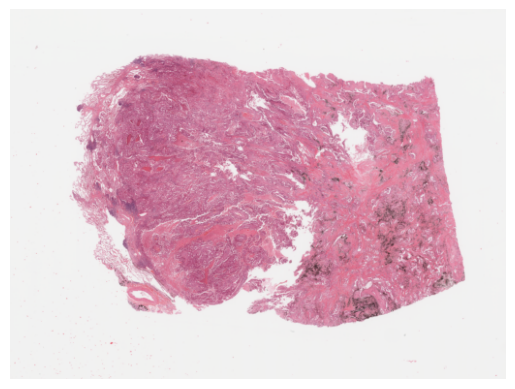

Tissue type:  lscc
Available levels: 
Level: 0, size: Size(width=87648, height=44205) px, mpp: SizeMm(width=0.5031, height=0.5031) um/px Instances: [0]: default z: 0.0 default path: 1 ImageData WsiDicomFileImageData of files odict_values([<wsidicom.file.io.wsidicom_reader.WsiDicomReader object at 0x7d6a6ee7bf70>])
Level: 2, size: Size(width=21912, height=11051) px, mpp: SizeMm(width=2.0124, height=2.0124) um/px Instances: [0]: default z: 0.0 default path: 1 ImageData WsiDicomFileImageData of files odict_values([<wsidicom.file.io.wsidicom_reader.WsiDicomReader object at 0x7d6a70fb7130>])
Level: 4, size: Size(width=5478, height=2762) px, mpp: SizeMm(width=8.0496, height=8.0496) um/px Instances: [0]: default z: 0.0 default path: 1 ImageData WsiDicomFileImageData of files odict_values([<wsidicom.file.io.wsidicom_reader.WsiDicomReader object at 0x7d6a6ee622c0>])
Level: 5, size: Size(width=2739, height=1381) px, mpp: SizeMm(width=16.0992, height=16.0992) um/px Instances: [0]: default z: 0.0 

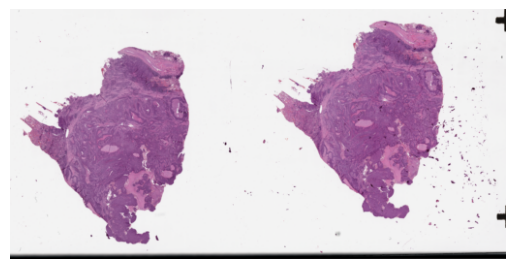

Tissue type:  normal
Available levels: 
Level: 0, size: Size(width=61751, height=47011) px, mpp: SizeMm(width=0.4942, height=0.4942) um/px Instances: [0]: default z: 0.0 default path: 1 ImageData WsiDicomFileImageData of files odict_values([<wsidicom.file.io.wsidicom_reader.WsiDicomReader object at 0x7d6a6eef9330>])
Level: 2, size: Size(width=15437, height=11752) px, mpp: SizeMm(width=1.976896041977, height=1.976896041977) um/px Instances: [0]: default z: 0.0 default path: 1 ImageData WsiDicomFileImageData of files odict_values([<wsidicom.file.io.wsidicom_reader.WsiDicomReader object at 0x7d6a726a3f40>])
Level: 4, size: Size(width=3859, height=2938) px, mpp: SizeMm(width=7.908096449857, height=7.908096449857) um/px Instances: [0]: default z: 0.0 default path: 1 ImageData WsiDicomFileImageData of files odict_values([<wsidicom.file.io.wsidicom_reader.WsiDicomReader object at 0x7d6a6d5307f0>])


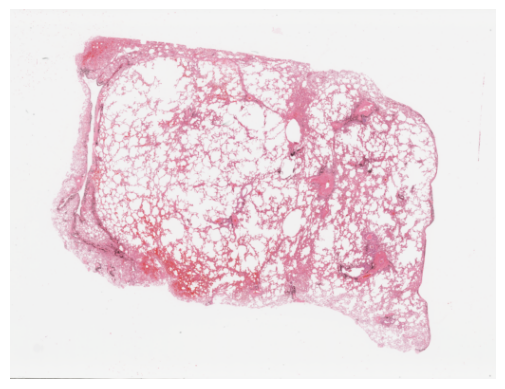

In [ ]:
from wsidicom import WsiDicom

for _, row in slides_metadata.iterrows():
    # Open slide with wsidicom
    slide = WsiDicom.open(row['local_path'])
    print('Tissue type: ', row['reference_class_label'])
    # Check which levels are available
    print('Available levels: ')
    for level in slide.levels:
        print(level)
    # Plot overview image
    plt.imshow(slide.read_thumbnail(size=(512,512)))
    plt.axis('off')
    plt.show()

Now we do the same thing with **openslide**:

Tissue type:  luad
Available levels: 
3
((43823, 32717), (10955, 8179), (2738, 2044))
(1.0, 4.000198055946843, 16.005919264851144)


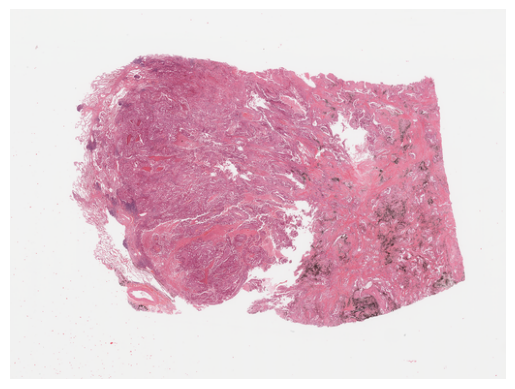

Tissue type:  lscc
Available levels: 
4
((87648, 44205), (21912, 11051), (5478, 2762), (2739, 1381))
(1.0, 4.0000452447742285, 16.002353367125274, 32.00470673425055)


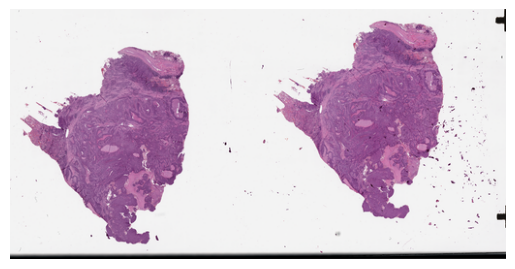

Tissue type:  normal
Available levels: 
3
((61751, 47011), (15437, 11752), (3859, 2938))
(1.0, 4.0002248069879585, 16.001417522113307)


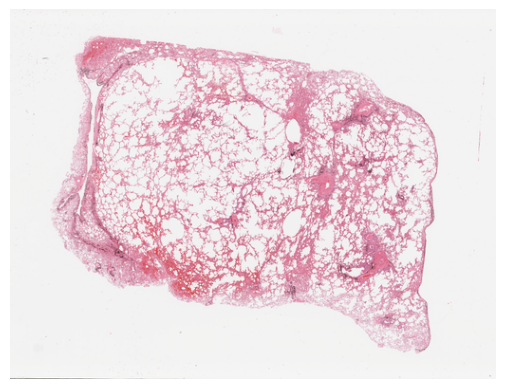

In [ ]:
from openslide import OpenSlide

for _, row in slides_metadata.iterrows():
    # Open slide with openslide
    file_path = os.path.join(row['local_path'], os.listdir(row['local_path'])[0])
    slide = OpenSlide(file_path)
    print('Tissue type: ', row['reference_class_label'])
    # Check which levels are available
    print('Available levels: ')
    for level_info in (slide.level_count, slide.level_dimensions, slide.level_downsamples):
        print(level_info)
    # Plot overview image
    plt.imshow(slide.get_thumbnail(size=(512,512)))
    plt.axis('off')
    plt.show()

**Note: we can of course do much more with wsidicom and openslide. Could be mentioned or shown.**

# Part 2: Pre-trained model inference

The TCGA-trained model that we use here was made available open source as part of the publication [The NCI Imaging Data Commons as a platform for reproducible research in computational pathology](https://doi.org/10.1016/j.cmpb.2023.107839). The specific model used here is a demo version, meaning that it was trained using slides at reduced magnification (pixel spacing of 0.002 mm/px instead of 0.001 mm/px) and will thus also be applied to slides at this resolution. The model is available as Github release asset and can be retrieved via curl.

## Prediction
**Prediction** is performed in a single sequential pass over the data. Each slide is accessed one after another, tiled and a prediction is made for each tile showing tissue (as determined by the `is_foreground` function). Tiles are not stored on the VM during this process.

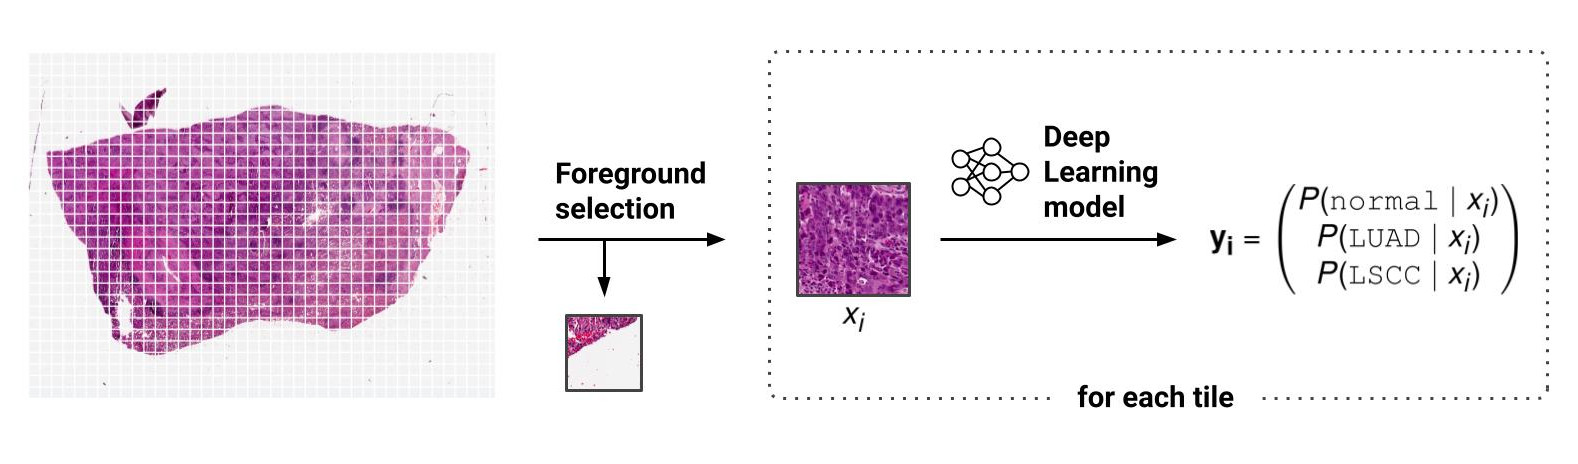

In [ ]:
LEVEL = 2
TILE_SIZE = 128 # in px
MODEL_URL = 'https://api.github.com/repos/ImagingDataCommons/idc-comppath-reproducibility/releases/assets/98547212'
MODEL_FILE_PATH = './tcga_pretrained_model128.zip'

In [ ]:
!curl --progress-bar -LJO \
   -H "Accept: application/octet-stream" \
   $MODEL_URL

!unzip -n $MODEL_FILE_PATH

############################################################################################# 100.0%
Archive:  ./tcga_pretrained_model128.zip
   creating: tcga_pretrained_model128/
  inflating: tcga_pretrained_model128/keras_metadata.pb  
  inflating: tcga_pretrained_model128/saved_model.pb  
   creating: tcga_pretrained_model128/variables/
  inflating: tcga_pretrained_model128/variables/variables.index  
  inflating: tcga_pretrained_model128/variables/variables.data-00000-of-00001  
   creating: tcga_pretrained_model128/assets/


In [ ]:
# Load model
tcga_model_dir = os.path.splitext(MODEL_FILE_PATH)[0]
model = load_model(tcga_model_dir, compile=False)

In [ ]:
def is_foreground(tile: Image.Image) -> bool:
    """
    Function to determine if a tile shows mainly tissue (foreground) or background.
    Returns True if tile shows <= 50% background and False otherwise.
    """
    grey = tile.convert(mode='L')
    thresholded = grey.point(lambda x: 0 if x < 220 else 1, mode='F')
    avg_bkg = np.average(np.array(thresholded))
    return avg_bkg <= 0.5

def predict(model, slides_metadata: pd.DataFrame, coverage: float) -> Predictions:
    """
    Function to perform inference for a certain set of slides using a given pretrained model.
    Returns per-tile predictions as obtained from the model inference plus necessary metadata, e.g.,
    the tile's position in the WSI.
    """
    image_ids = []
    tile_positions = []
    reference_class_indices = []
    predicted_class_probabilities = []

    for index, slide_metadata in tqdm(slides_metadata.iterrows(), total=slides_metadata.shape[0]):
        wsi = WsiDicom.open(slide_metadata['local_path'])
        image_id = slide_metadata['digital_slide_id']
        reference_class_index = CLASS_LABEL_TO_INDEX_MAP[slide_metadata['reference_class_label']]
        batch_iterator = BatchIterator(wsi, TILE_SIZE, LEVEL, is_foreground,
                                    batch_size=32, coverage=coverage)

        for (batch_images, batch_tile_positions) in batch_iterator:
            batch_predicted_class_probabilities = model(batch_images).numpy()
            image_ids.extend([image_id] * len(batch_tile_positions))
            tile_positions.extend(batch_tile_positions)
            reference_class_indices.extend([reference_class_index] * len(batch_tile_positions))
            predicted_class_probabilities.extend(batch_predicted_class_probabilities.tolist())

    dictionary = {'image_id': image_ids, 'tile_position': tile_positions,
            'reference_class_index': reference_class_indices,
            'predicted_class_index': [p.index(max(p)) for p in predicted_class_probabilities],
            'predicted_class_probabilities': predicted_class_probabilities}

    return Predictions(pd.DataFrame(dictionary))

In [ ]:
# Perform prediction
predictions = predict(model, slides_metadata, coverage=1.0)

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
display(predictions._predictions.head())

,image_id,tile_position,reference_class_index,predicted_class_index,predicted_class_probabilities
0,1.3.6.1.4.1.5962.99.1.260210968.1781131012.164...,"(29, 19)",1,2,"[0.010702917352318764, 0.42096197605133057, 0...."
1,1.3.6.1.4.1.5962.99.1.260210968.1781131012.164...,"(44, 23)",1,2,"[0.01806052029132843, 0.03235547989606857, 0.9..."
2,1.3.6.1.4.1.5962.99.1.260210968.1781131012.164...,"(27, 8)",1,2,"[0.019017690792679787, 0.011343630962073803, 0..."
3,1.3.6.1.4.1.5962.99.1.260210968.1781131012.164...,"(42, 33)",1,2,"[0.30212080478668213, 0.06057902052998543, 0.6..."
4,1.3.6.1.4.1.5962.99.1.260210968.1781131012.164...,"(38, 16)",1,2,"[0.09840059280395508, 0.057496458292007446, 0...."


## Evaluation

**Heatmaps** are generated for visually inspecting the network's predictions for our three slides. The color of each tile in the heatmap corresponds to the class assigned by our model. The hue indicates how confident the network is in this classification. Hereby, a darker hue corresponds to higher confidence. The respective orginal WSI is shown as thumbnail image next to the heatmap.

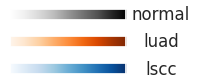

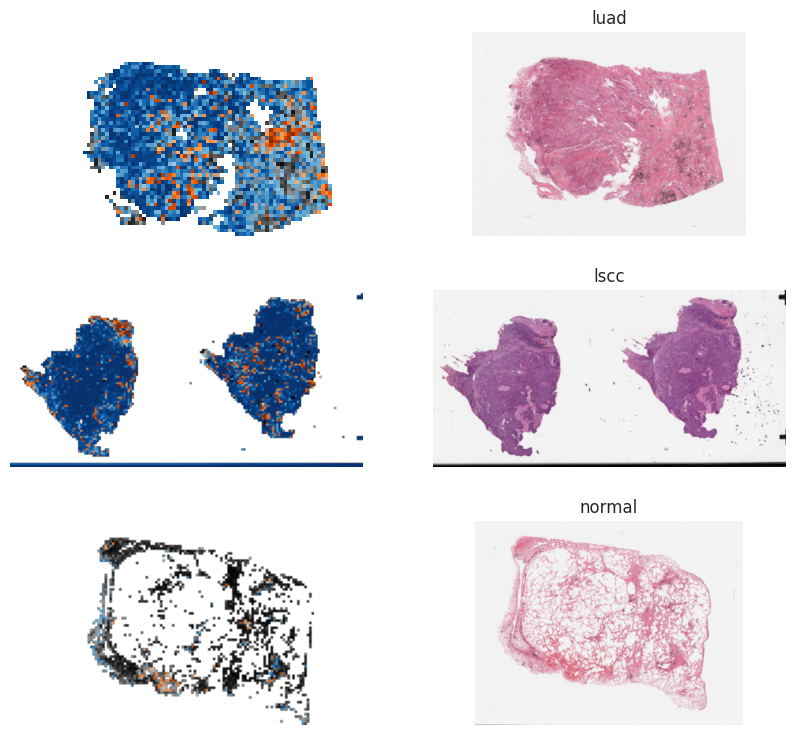

In [ ]:
plot_colormap_legend()
fig, axes = plt.subplots(3, 2, figsize=(10, 9))
for i, (image_id, slide_metadata) in enumerate(slides_metadata.iterrows()):
    wsi = WsiDicom.open(slide_metadata['local_path'])
    thumbnail = wsi.read_thumbnail()
    true_tissue_type = slide_metadata['reference_class_label']
    heatmap = generate_heatmap(predictions, image_id)
    axes[i,0].imshow(heatmap)
    axes[i,1].imshow(thumbnail)
    axes[i,1].set_title(true_tissue_type)
    axes[i,0].axis('off')
    axes[i,1].axis('off')

---
*The results shown here are in whole or part based upon data generated by the The Cancer Genome Atlas (TCGA) Research Network and the National Cancer Institute Clinical Proteomic Tumor Analysis Consortium (CPTAC).*

*Copyright 2024 Fraunhofer MEVIS and Harvard Medical School. Redistribution and use of this notebook, with or without modification, are permitted under the terms of the [3-Clause BSD License](https://opensource.org/licenses/BSD-3-Clause).*